As always, import the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline
#import seaborn as sns

# custom functions for data preparation
import ex1_functions as ff

/home/gael/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Supervised learning

In this notebook, we will train a Random Forest Classifier on the soccer data we handled in the notebook *1_Analysis_and_Cleaning*.

We start by selecting a first set of features and exploring various parameters for the classifier. After obtaining results for this first set, we test two other groups of features.

We discuss our results and their possible causes.

First, we import the numeric data we prepared:

In [2]:
df = pd.read_csv('data/players_with_features_no_nan_only_num_values.csv').drop('index', axis=1)
df.head(3)

,games,goals,height,skin_colour,redCards,ties,victories,defeats,yellowReds,yellowCards,weight,gravity,meanIAT_yellowCards,meanIAT_yellowReds,meanIAT_redCards,meanIAT_gravity,meanExp_yellowCards,meanExp_yellowReds,meanExp_redCards,meanExp_gravity
0,654,9,182.0,0.125,0,179,247,228,0,19,71.0,19.000000,0.011600,0.0,0.000000,0.011600,0.012772,0.0,0.000000,0.012772
1,336,62,183.0,0.125,1,73,141,122,0,42,73.0,73.305853,0.036043,0.0,0.000297,0.045332,0.041615,0.0,0.000358,0.052832
2,412,31,165.0,0.250,0,97,200,115,0,11,63.0,11.000000,0.006122,0.0,0.000000,0.006122,0.006491,0.0,0.000000,0.006491


## Which classification?
Remember, the *skin_colour* column is actually the average rating over the two raters. Let's bring up its values:

In [3]:
df.skin_colour.unique()

array([ 0.125,  0.25 ,  0.   ,  0.75 ,  0.875,  1.   ,  0.375,  0.5  ,
        0.625])

As it stands, there are 9 values that encode skin colour. 

### Assumption
We make the choice to reduce these values to only two categories, which we believe are enough to roughly determine a person's skin colour. Thus, we reduce our problem to binary classification.

## First set of features

As a test, we train a random forest on all the features of our data that have a link to player-referee interactions, and thus may contain a hint of racism.

In [4]:
# comment out the features you want to pass to the classifier!
cols1 = ['height', 
        'weight', 
        'games', 
        'victories', 
        'ties', 
        'defeats', 
        'goals', 
        #'yellowCards',
        #'yellowReds',
        #'redCards',
        'skin_colour', 
        #'gravity',
        #'meanIAT_yellowCards',
        #'meanIAT_yellowReds', 
        #'meanIAT_redCards',
        #'meanIAT_gravity',
        #'meanExp_yellowCards',
        #'meanExp_yellowReds', 
        #'meanExp_redCards',
        #'meanExp_gravity'
       ]

We prepare our data in the correct format with the help of functions stored in *1_functions.py*.

In [5]:
# choose the appropriate separator for skin_colour
b = ff.binary_separator
# transform the df into np matrix
data, target, labels = ff.prepare_data(df, cols1, b)

df shape: (1305, 20)
data shape: (1305, 12)
target shape: (1305,)


Let's check if there is any class imbalance:

In [6]:
x = df.skin_colour.apply(ff.binary_separator)

In [7]:
x.value_counts()

0.0    1113
1.0     192
Name: skin_colour, dtype: int64

As it turns out, there is a huge class imbalance. We will see later wether it's a problem for us. We just check the percentage to have a better idea than just numbers.

In [8]:
x.value_counts()*100/x.count()

0.0    85.287356
1.0    14.712644
Name: skin_colour, dtype: float64

### Setting the parameters
One parameter we're interested in when instantiating a random forest is its number of estimators. 

Thus, we iterate over a number of forests with a different number of estimators and use the OOB score to figure out how many estimators is enough. Our *ff.train_test_RF()* function performs a train/test split on the data to train the random forest. It also holds some data out of the train/test samples, to perform a check on data the classifier hasn't seen before.

In [9]:
oob = []
for i in range(5, 200, 1):
    forest = RandomForestClassifier(n_estimators = i, max_features=0.33, max_depth=10, n_jobs=-1, oob_score=True);
    forest, acc = ff.train_test_RF(forest, data, target, 150);
    oob.append(1-forest.oob_score_);
    if ((i-5)+1)%10 == 0:
        print("%i/%i done!"%((i-5)+1, 200-5))
print("All done!")

10/195 done!
20/195 done!
30/195 done!
40/195 done!
50/195 done!
60/195 done!
70/195 done!
80/195 done!
90/195 done!
100/195 done!
110/195 done!
120/195 done!
130/195 done!
140/195 done!
150/195 done!
160/195 done!
170/195 done!
180/195 done!
190/195 done!
All done!


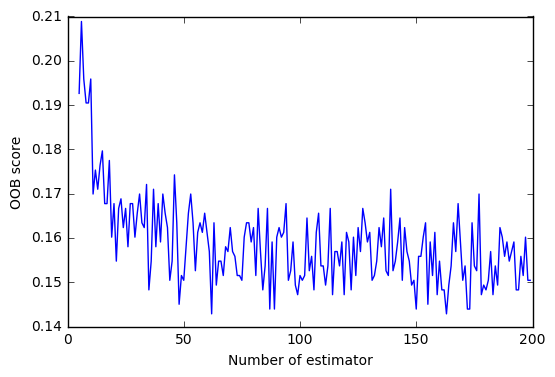

In [10]:
plt.plot(range(5, 200, 1), oob, '-')
plt.xlabel('Number of estimator')
plt.ylabel('OOB score')

As we can see, although it is still rough, the error starts to stabilise between 50 and 100 estimators. We'll use 100 estimators to be sure.

We do the same to set the depth parameter. This time, we use the accuracy score on the held-out sample.

In [11]:
acc = []
for i in range(1, 50, 1):
    forest = RandomForestClassifier(n_estimators = 100, max_features=0.33, max_depth=i, n_jobs=-1, oob_score=True);
    forest, accuracy = ff.train_test_RF(forest, data, target, 150);
    acc.append(1-accuracy);
    if (i+1)%10 == 0:
        print("%i/%i done!"%((i+1, 50)))
print("All done!")

10/50 done!
20/50 done!
30/50 done!
40/50 done!
50/50 done!
All done!


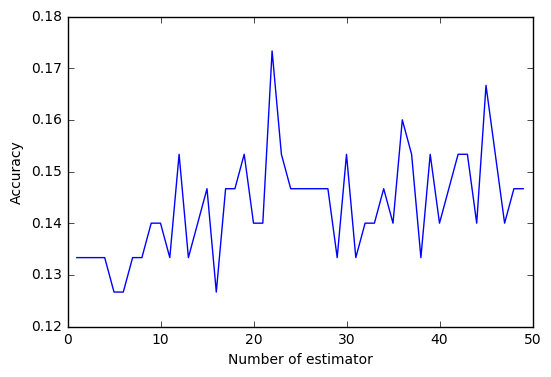

In [12]:
plt.plot(range(1, 50, 1), acc, '-')
plt.xlabel('Number of estimator')
plt.ylabel('Accuracy')

Here we see that it seems better to have a *max_depth* of only ~10.

### Cross-validation

We fit our random forest classifier using cross-validation, so as to avoid overfitting. We use KFold to do so. Also, we hold out same data to see how our classifier behaves on data it hasn't seen before.

In [13]:
# preparing the hold-out data
n = len(target)-50
data_holdout = data[n:,]
target_holdout = target[n:]
data = data[:n,]
target = target[:n]

# we will keep track of the accuracy
acc = []
forest = RandomForestClassifier(n_estimators = 100, max_features=0.33, max_depth=8, n_jobs=-1)
kf = KFold(n_splits=20)

for train, test in kf.split(data):
    forest.fit(data[train], target[train])
    # keeping track of the accuracy
    predi = forest.predict(data[test])
    acc.append(metrics.accuracy_score(predi, target[test]))

First, let's see how it behaves on the data it has already worked on:

In [14]:
pred = forest.predict(data)
metrics.accuracy_score(pred, target)

0.86374501992031871

At first sight, this doesn't seem too bad. But *accuracy* might not be a good measure here. Remember, we have a strong class imbalance. 

To get a clearer picture, we separate our target and prediction data into the two classes and check accuracy for each class.

In [15]:
# divide into two classes
target0 = []
pred0 = []

target1 = []
pred1 = []

for i, t in enumerate(target):
    if t:
        target1.append(t)
        pred1.append(pred[i])
    else:
        target0.append(t)
        pred0.append(pred[i])
        
print('# of people with light skin: %s' % len(target0))
print('# of people with dark skin: %s' % len(target1))
print(' ')
print('accuracy for light skin: %s' % metrics.accuracy_score(target0, pred0))
print('accuracy for dark skin: %s' % metrics.accuracy_score(target1, pred1))

# of people with light skin: 1074
# of people with dark skin: 181
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.0552486187845


Something is clearly going awry here. We check the confusion matrix for a clearer picture.

In [16]:
cnf = metrics.confusion_matrix(target, pred)
cnf

array([[1074,    0],
       [ 171,   10]])

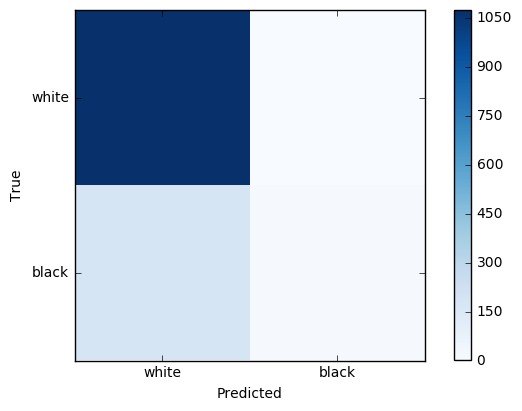

In [17]:
ff.plot_cnf(cnf, ['white', 'black'])

It is clear from the confusion matrix that our random forest is very much biased towards the *light skin* class. Almost all dark-skinned players are classified as light-skinned.

We check the results on the data we held out:

In [18]:
predi = forest.predict(data_holdout)

In [19]:
ff.details(predi, target_holdout)

 
# of people with light skin: 39
# of people with dark skin: 11
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.0


In [20]:
cnf = metrics.confusion_matrix(target_holdout, predi)
cnf

array([[39,  0],
       [11,  0]])

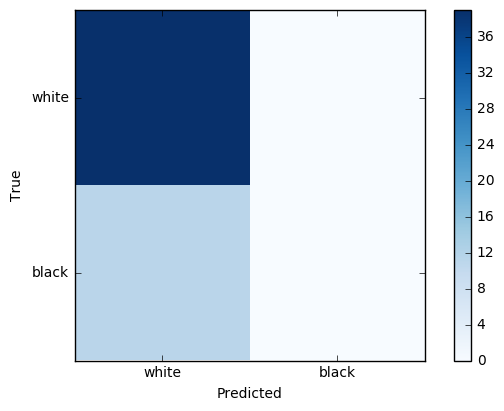

In [21]:
ff.plot_cnf(cnf, ['white', 'black'])

The predictions are even worse here, with all dark skinned players classified as light skinned.

The huge class imbalance probably explains it.

### Feature importances

Let's check the feature importances:

In [22]:
imp = forest.feature_importances_

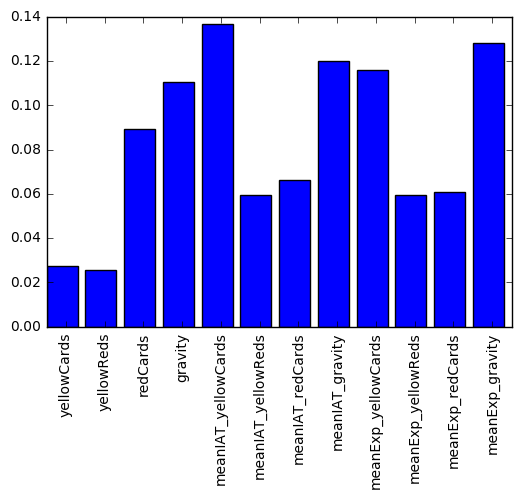

In [23]:
ff.impo_graph(imp, labels)

It seems that more importance is given to the features involving yellow cards. This is probably because there are substantially more players with yellow cards than red cards or yellow-reds.

Furthermore, we note that our cross-features, such as gravity, seem legitimate as they carry some importance!

## Second set of features

The first results were quite disappointing. Let's try to train the classifier on the features that have nothing to do with player-referee interactions.

In [24]:
# comment out the features you want to pass to the classifier!
cols2 = [#'height', 
        #'weight', 
        #'games', 
        #'victories', 
        #'ties', 
        #'defeats', 
        #'goals', 
        'yellowCards',
        'yellowReds',
        'redCards',
        'skin_colour', 
        'gravity',
        'meanIAT_yellowCards',
        'meanIAT_yellowReds', 
        'meanIAT_redCards',
        'meanIAT_gravity',
        'meanExp_yellowCards',
        'meanExp_yellowReds', 
        'meanExp_redCards',
        'meanExp_gravity'
       ]

In [25]:
forest, cnf, cnf_holdout, labels = ff.whole_process(df, cols2, ff.binary_separator)

df shape: (1305, 20)
data shape: (1305, 7)
target shape: (1305,)
 
predicting..
 
Accuracy details for whole data:
 
# of people with light skin: 1074
# of people with dark skin: 181
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.281767955801
 
Accuracy details for holdout data:
 
# of people with light skin: 39
# of people with dark skin: 11
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.0909090909091


Although the accuracy on previously seen data (for dark skinned players) seems slightly better, it is still worse than a coin toss.. We plot the confusion matrices for the data and the held-out data.

[[1074    0]
 [ 130   51]]


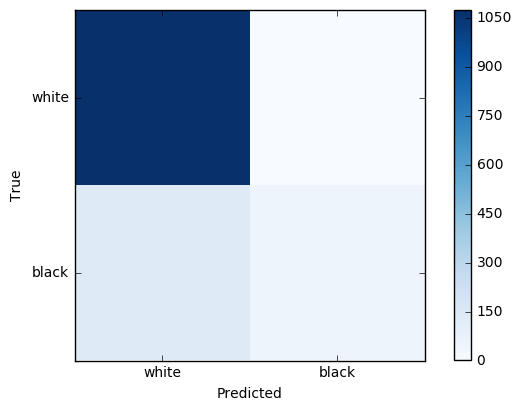

In [26]:
print(cnf)
ff.plot_cnf(cnf, ['white', 'black'])

[[39  0]
 [10  1]]


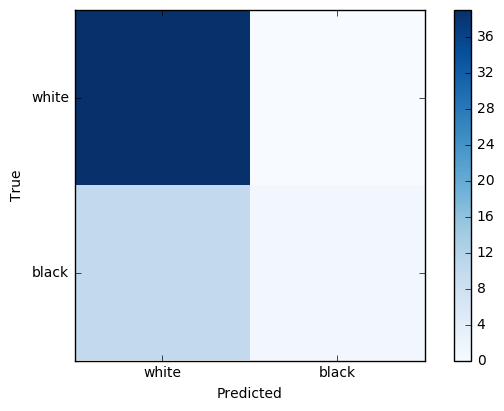

In [27]:
print(cnf_holdout)
ff.plot_cnf(cnf_holdout, ['white', 'black'])

The results on the held-out data are still deplorable.

In [28]:
imp = forest.feature_importances_

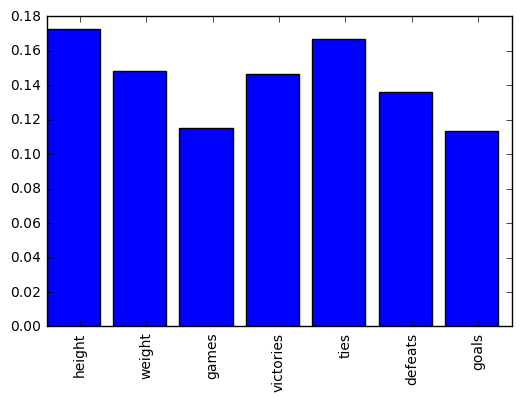

In [29]:
ff.impo_graph(imp, labels)

We used features that have nothing to do with potential racism, and surprisingly the results can be considered to be a bit better than with the first set.

Let's try a third set, combining the most important features of both attempts.

## Third set of features

In [30]:
# comment out the features you want to pass to the classifier!
cols3 = ['height', 
        'weight', 
        #'games', 
        #'victories', 
        'ties', 
        'defeats', 
        #'goals', 
        'yellowCards',
        'yellowReds',
        #'redCards',
        'skin_colour', 
        #'gravity',
        #'meanIAT_yellowCards',
        'meanIAT_yellowReds', 
        'meanIAT_redCards',
        #'meanIAT_gravity',
        #'meanExp_yellowCards',
        'meanExp_yellowReds', 
        'meanExp_redCards',
        #'meanExp_gravity'
       ]

In [31]:
forest, cnf, cnf_holdout, labels = ff.whole_process(df, cols3, ff.binary_separator)

df shape: (1305, 20)
data shape: (1305, 9)
target shape: (1305,)
 
predicting..
 
Accuracy details for whole data:
 
# of people with light skin: 1074
# of people with dark skin: 181
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.298342541436
 
Accuracy details for holdout data:
 
# of people with light skin: 39
# of people with dark skin: 11
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.0909090909091


Seems to be bit better, but still painfully low on dark-skinned players!

[[1074    0]
 [ 127   54]]


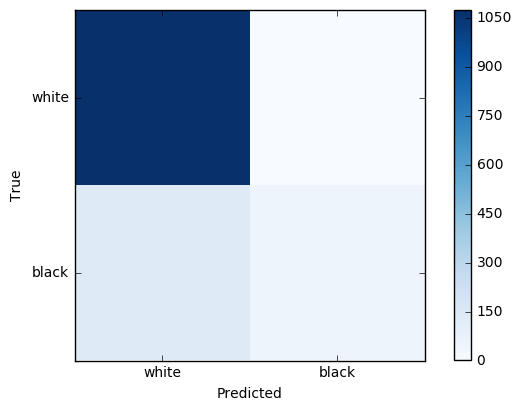

In [32]:
print(cnf)
ff.plot_cnf(cnf, ['white', 'black'])

[[39  0]
 [10  1]]


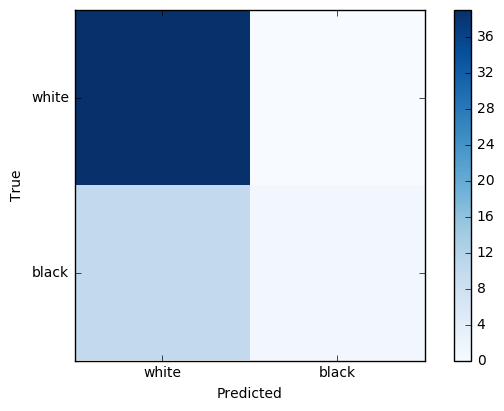

In [33]:
print(cnf_holdout)
ff.plot_cnf(cnf_holdout, ['white', 'black'])

In [34]:
imp = forest.feature_importances_

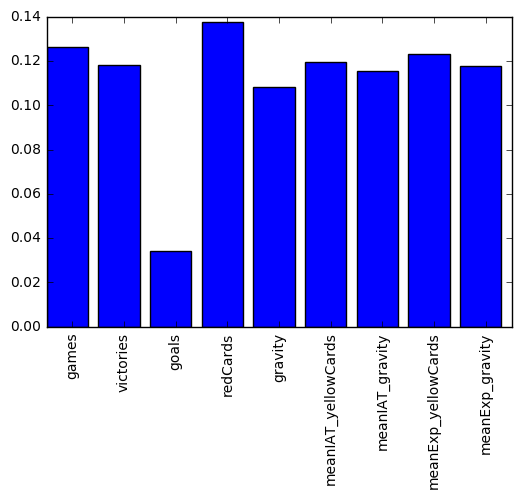

In [35]:
ff.impo_graph(imp, labels)

We realize once again that both racism-related and racsim-unrelated features have equal importance.

# Discussion

Whatever the set of features selected, we obtained poor results when it comes to accurately classifying players, in particular those with dark skin. Careful selection of equally sized samples would eliminate class imbalance and might help. The problem is that the resulting data would be of small size.

While the class imbalance probably plays a big role, we believe the conclusion to be drawn here is that the data we have simply does not allow us to predict skin colour.

Furthermore, the fact that we didn't obtain worse results when considering non-racism-related features could be invoked to assert that referee racism and behavior is not strong enough to predict players' skin colour. That's good news!

# Bonus

Code reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

With the help of the code mentioned above, we plot the learning curves for our *first* and *third* sets of features.

df shape: (1305, 20)
data shape: (1305, 12)
target shape: (1305,)


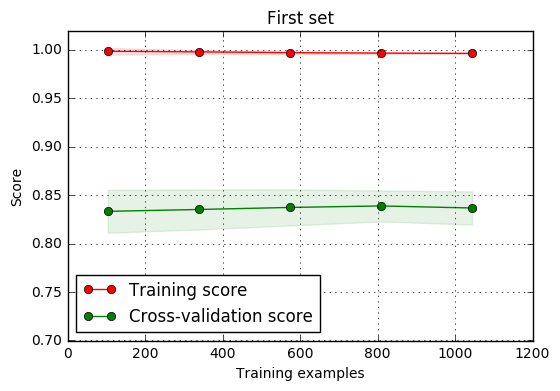

In [36]:
# first set of features
b = ff.binary_separator
data, target, labels = ff.prepare_data(df, cols1, b)
ff.make_learning_curve(data, target, 'First set')

df shape: (1305, 20)
data shape: (1305, 9)
target shape: (1305,)


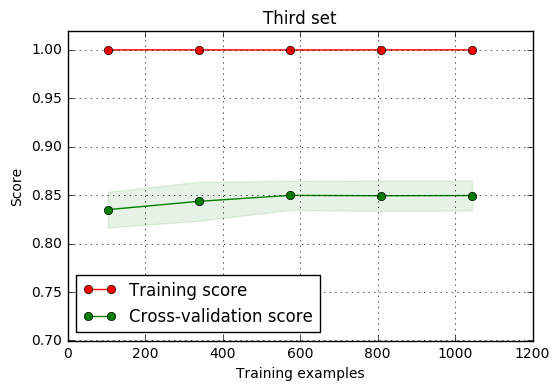

In [37]:
# third set of features
b = ff.binary_separator
data, target, labels = ff.prepare_data(df, cols3, b)
ff.make_learning_curve(data, target, 'Third set')

It seems that the feature set doesn't influence the learning curve much in this case. Although the second one is slightly more increasing, both are pretty similar, with a training score curve that indicates painful overfitting, despite the cross validation procedure, and biased results.

This reflects the discussion above. Checking every possible combination of features would be far too long. We believe however that the data is such that no group of features would lead to better results on this classification problem.